# U.S. Medical Insurance Costs

In [22]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

In [23]:
!pip install -q xgboost

In [24]:
df = pd.read_csv('Insurance.csv')
print(df.head())

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


In [25]:


# Encode categorical variables 
data = df.copy()
categorical_cols = ['sex', 'smoker', 'region']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Create interaction terms
data['age_bmi'] = data['age'] * data['bmi']
data['smoker_yes_bmi'] = data['smoker_yes'] * data['bmi'] if 'smoker_yes' in data else 0

# Log-transform the target
data['log_charges'] = np.log(data['charges'])

# Set features and targets
X = data.drop(['charges', 'log_charges'], axis=1)
y = data['charges']
y_log = data['log_charges']

In [26]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

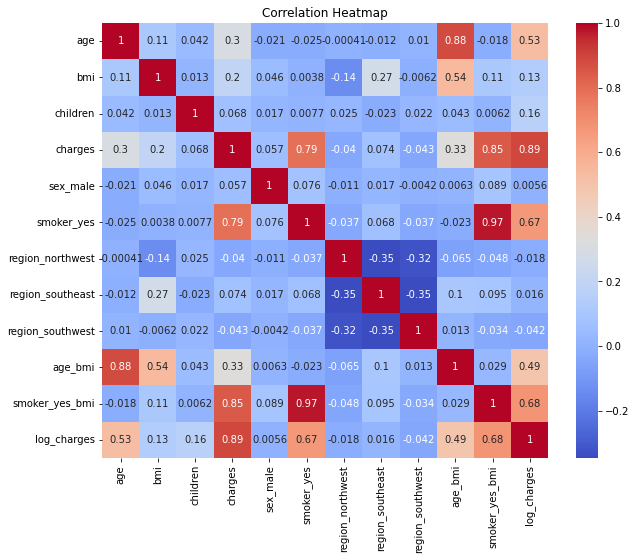

In [27]:
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [28]:
def evaluate_model(model, X_tr, X_te, y_tr, y_te, y_tr_orig=None, y_te_orig=None, log_target=False):
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    if log_target:
        y_pred_exp = np.exp(y_pred)
        y_te_exp = np.exp(y_te)
        mae = mean_absolute_error(y_te_exp, y_pred_exp)
        rmse = mean_squared_error(y_te_exp, y_pred_exp, squared=False)
        r2 = r2_score(y_te_exp, y_pred_exp)
    else:
        mae = mean_absolute_error(y_te, y_pred)
        rmse = mean_squared_error(y_te, y_pred, squared=False)
        r2 = r2_score(y_te, y_pred)
    print(f"MAE: {mae:.2f} | RMSE: {rmse:.2f} | R2: {r2:.3f}")
    return y_pred

In [29]:
print("Linear Regression (original target):")
linreg = LinearRegression()
y_pred_lin = evaluate_model(linreg, X_train, X_test, y_train, y_test)

print("\nLinear Regression (log target):")
linreg_log = LinearRegression()
y_pred_lin_log = evaluate_model(linreg_log, X_train_log, X_test_log, y_train_log, y_test_log, log_target=True)

Linear Regression (original target):
MAE: 2759.83 | RMSE: 4567.66 | R2: 0.866

Linear Regression (log target):
MAE: 3941.01 | RMSE: 8386.70 | R2: 0.547


In [30]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(linreg, X, y, cv=cv, scoring='neg_mean_absolute_error')
print("\nCV MAE (Linear Regression):", -np.mean(cv_scores))


CV MAE (Linear Regression): 2924.131408612676


In [31]:
print("\nDecision Tree Regression:")
dtree = DecisionTreeRegressor(random_state=42)
y_pred_tree = evaluate_model(dtree, X_train, X_test, y_train, y_test)

print("\nRandom Forest Regression:")
rf = RandomForestRegressor(random_state=42)
y_pred_rf = evaluate_model(rf, X_train, X_test, y_train, y_test)


Decision Tree Regression:
MAE: 2833.02 | RMSE: 6237.39 | R2: 0.749

Random Forest Regression:
MAE: 2444.24 | RMSE: 4487.97 | R2: 0.870


In [32]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8]
}
grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='neg_mean_absolute_error')
grid_rf.fit(X_train, y_train)
print("Best params (RF):", grid_rf.best_params_)

Best params (RF): {'max_depth': 6, 'n_estimators': 200}


In [33]:
print("\nGradient Boosting Regression:")
gbr = GradientBoostingRegressor(random_state=42)
y_pred_gbr = evaluate_model(gbr, X_train, X_test, y_train, y_test)

# Optional: Hyperparameter tuning for Gradient Boosting
param_grid_gb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1]
}
grid_gb = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid_gb, cv=3, scoring='neg_mean_absolute_error')
grid_gb.fit(X_train, y_train)
print("Best params (GBR):", grid_gb.best_params_)


Gradient Boosting Regression:
MAE: 2477.72 | RMSE: 4374.76 | R2: 0.877
Best params (GBR): {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}


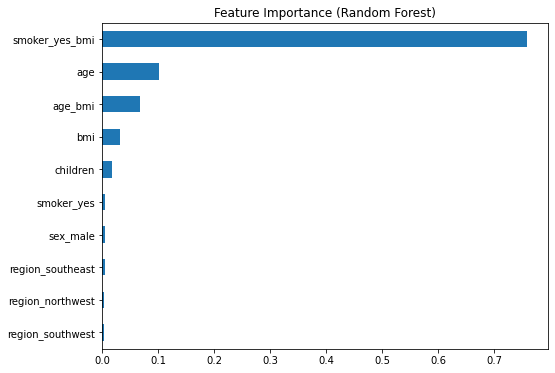

In [34]:
# For Random Forest
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.sort_values().plot(kind='barh', figsize=(8,6))
plt.title("Feature Importance (Random Forest)")
plt.show()

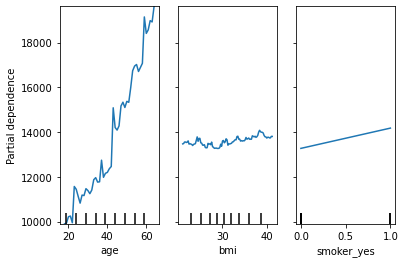

In [35]:
PartialDependenceDisplay.from_estimator(rf, X, ['age', 'bmi', 'smoker_yes'])
plt.show()

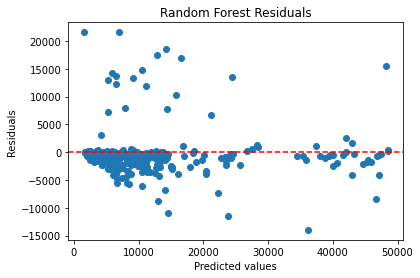

In [36]:
def plot_residuals(y_true, y_pred, title):
    residuals = y_true - y_pred
    plt.scatter(y_pred, residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted values")
    plt.ylabel("Residuals")
    plt.title(title)
    plt.show()

plot_residuals(y_test, y_pred_rf, "Random Forest Residuals")


In [37]:
import os
os.getcwd()

'C:\\Users\\Leo\\codecademy'